In [6]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import sys
import time

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('alya_formatted_2.csv', header=0, index_col=0)
values = dataset.values

n_days_predict=5
n_features=5


# ensure all data is float
values = values.astype('float64')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_days_predict, 1)


# split into train and test sets
values = reframed.values
n_train_set = 2100
train = values[:n_train_set, :]
test = values[n_train_set:, :]

# split into input and outputs
n_obs = n_days_predict * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

#print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

#print shape of tensors
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print ('Training set:')
print (len(train_X))
print ('Test set: ')
print (len(test_X))

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=1500, validation_data = (test_X, test_y), verbose=2, shuffle=False)

# plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.title('LSTM Loss')
# pyplot.xlabel('epochs')
# pyplot.ylabel('loss')
# pyplot.legend()
# pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMS 
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
# pyplot.legend()
# pyplot.show()

# pyplot.plot(test_y, color = 'red', label = 'Real price')
# pyplot.plot(inv_yhat, color= 'blue', label = 'predicted price')

# pyplot.title('price prediction')
# pyplot.xlabel('days')
# pyplot.ylabel('price')
# pyplot.legend()
# pyplot.show()

Training set:
2100
Test set: 
881
Train on 2100 samples, validate on 881 samples
Epoch 1/300
 - 1s - loss: 0.2270 - val_loss: 0.4204
Epoch 2/300
 - 0s - loss: 0.1883 - val_loss: 0.3663
Epoch 3/300
 - 0s - loss: 0.1574 - val_loss: 0.3139
Epoch 4/300
 - 0s - loss: 0.1317 - val_loss: 0.2670
Epoch 5/300
 - 0s - loss: 0.1123 - val_loss: 0.2289
Epoch 6/300
 - 0s - loss: 0.0977 - val_loss: 0.1998
Epoch 7/300
 - 0s - loss: 0.0866 - val_loss: 0.1771
Epoch 8/300
 - 0s - loss: 0.0777 - val_loss: 0.1586
Epoch 9/300
 - 0s - loss: 0.0701 - val_loss: 0.1423
Epoch 10/300
 - 0s - loss: 0.0634 - val_loss: 0.1278
Epoch 11/300
 - 0s - loss: 0.0576 - val_loss: 0.1148
Epoch 12/300
 - 0s - loss: 0.0524 - val_loss: 0.1032
Epoch 13/300
 - 0s - loss: 0.0474 - val_loss: 0.0932
Epoch 14/300
 - 0s - loss: 0.0426 - val_loss: 0.0846
Epoch 15/300
 - 0s - loss: 0.0377 - val_loss: 0.0770
Epoch 16/300
 - 0s - loss: 0.0329 - val_loss: 0.0699
Epoch 17/300
 - 0s - loss: 0.0285 - val_loss: 0.0631
Epoch 18/300
 - 0s - loss: 

 - 0s - loss: 0.0072 - val_loss: 0.0153
Epoch 154/300
 - 0s - loss: 0.0066 - val_loss: 0.0135
Epoch 155/300
 - 0s - loss: 0.0073 - val_loss: 0.0180
Epoch 156/300
 - 0s - loss: 0.0072 - val_loss: 0.0152
Epoch 157/300
 - 0s - loss: 0.0065 - val_loss: 0.0134
Epoch 158/300
 - 0s - loss: 0.0073 - val_loss: 0.0181
Epoch 159/300
 - 0s - loss: 0.0072 - val_loss: 0.0152
Epoch 160/300
 - 0s - loss: 0.0065 - val_loss: 0.0133
Epoch 161/300
 - 0s - loss: 0.0073 - val_loss: 0.0179
Epoch 162/300
 - 0s - loss: 0.0071 - val_loss: 0.0152
Epoch 163/300
 - 0s - loss: 0.0064 - val_loss: 0.0132
Epoch 164/300
 - 0s - loss: 0.0073 - val_loss: 0.0178
Epoch 165/300
 - 0s - loss: 0.0071 - val_loss: 0.0151
Epoch 166/300
 - 0s - loss: 0.0064 - val_loss: 0.0133
Epoch 167/300
 - 0s - loss: 0.0072 - val_loss: 0.0179
Epoch 168/300
 - 0s - loss: 0.0071 - val_loss: 0.0150
Epoch 169/300
 - 0s - loss: 0.0064 - val_loss: 0.0133
Epoch 170/300
 - 0s - loss: 0.0071 - val_loss: 0.0181
Epoch 171/300
 - 0s - loss: 0.0072 - val_l

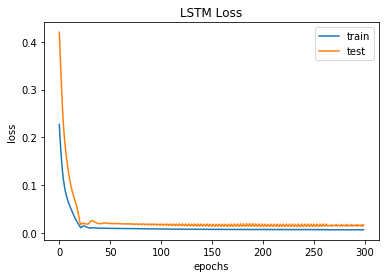

In [7]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('LSTM Loss')
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.legend()
pyplot.show()

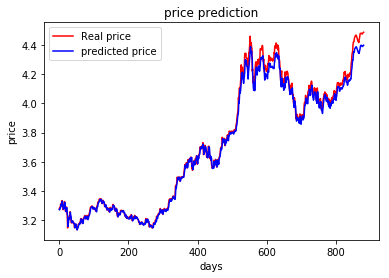

In [8]:
pyplot.plot(inv_y, color = 'red', label = 'Real price')
pyplot.plot(inv_yhat, color= 'blue', label = 'predicted price')

pyplot.title('price prediction')
pyplot.xlabel('days')
pyplot.ylabel('price')
pyplot.legend()
pyplot.show()